In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Packages containing functions required for the following classification model

In [2]:
cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
                          
cleveland_data<-cleveland_data|>
                    select(age, sex, max_heartrate, risk_level)|>
                    mutate(risk_level = as_factor(risk_level))|>
                    mutate(sex=case_when(sex==0~"female",sex==1~"male"))
cleveland_data

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,max_heartrate,risk_level
<dbl>,<chr>,<dbl>,<fct>
67,male,108,2
67,male,129,1
37,male,187,0
⋮,⋮,⋮,⋮
57,male,115,3
57,female,174,1
38,male,173,0


Processed Cleveland Heart Dataset: 
-obtained from UCI Machine Learning Repository-Center for Machine Learning and Intelligent Systems
-data cleaned and wrangled, changed variables to human readable names.
Note: generally 0=normal and 1-4=abnormal, presence of, or potential risk

In [3]:
set.seed(1111)

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = risk_level)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

cleveland_train
cleveland_test

age,sex,max_heartrate,risk_level
<dbl>,<chr>,<dbl>,<fct>
37,male,187,0
41,female,172,0
57,female,163,0
⋮,⋮,⋮,⋮
61,male,125,4
55,female,130,3
59,male,90,3


age,sex,max_heartrate,risk_level
<dbl>,<chr>,<dbl>,<fct>
56,male,178,0
57,male,148,0
56,male,142,2
⋮,⋮,⋮,⋮
35,male,174,0
58,male,140,4
57,male,115,3


Split original dataset to Training(75%) and Testing(25%). Training data will be used to design predictive model (classifier) in the following code.

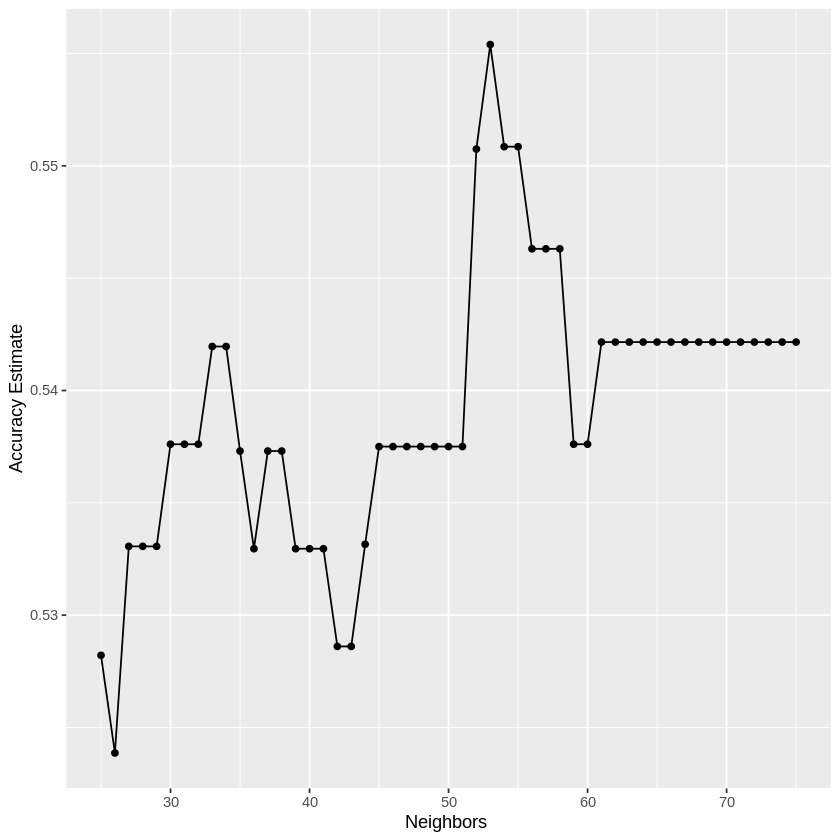

In [5]:
set.seed(2221)
heart_recipe <- recipe(risk_level ~ age+max_heartrate, data = cleveland_train) |>
                step_normalize(all_predictors())

heart_vfold <- vfold_cv(cleveland_train, v = 5, strata = risk_level)

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 25, to = 75, by = 1))

heart_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(heart_tune) |>
      tune_grid(resamples = heart_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- heart_fit |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors ", y = "Accuracy Estimate")

cross_val_plot

As seen in the Neighbours vs Accuracy Estimate above, using a k-neighbours value of 53, meaning any new observation will be compared with the closest 53 datapoints in the training data and classfied, will provide us with the highest accuracy.